# Movie Recommendation System

## Data preprocessing

In [1]:
# Import các thư viện cần thiết
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
import time
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import KNNBasic, KNNWithMeans, SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate


In [2]:
# Lấy file data
df = pd. read_csv('movies_metadata.csv')
df.head()

C:\Users\maver\AppData\Local\Temp\ipykernel_13092\296701214.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd. read_csv('movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
# kiểm tra dataset có bao nhiêu phim tất cả
print('The movie dataset has', df['id'].nunique(), 'unique movies')

The movie dataset has 45436 unique movies


In [5]:
# Kiểm tra các cột có số lượng giá trị trống nhiều nhất
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis = 1, keys=['Total', '%'])
missing_data.head(30)

,Total,%
belongs_to_collection,40972,90.1
homepage,37684,82.9
tagline,25054,55.1
overview,954,2.1
poster_path,386,0.8
runtime,263,0.6
status,87,0.2
release_date,87,0.2
imdb_id,17,0.0
original_language,11,0.0


In [6]:
#Xử lý tách năm trong cột ngày sản xuất ra thành 1 cột năm sản xuất riêng
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [7]:
# Chọn các cột cần thiết cho bài toán 
df= df[['id', 'genres', 'imdb_id','overview' , 'original_title', 'original_language', 'year']]
df = df[df['original_language']== 'en']
df = df.dropna(subset=['overview'])
df = df.dropna(subset=['imdb_id'])
df = df.reset_index(drop=True)

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis = 1, keys=['Total', '%'])
missing_data.head(30)

,Total,%
id,0,0.0
genres,0,0.0
imdb_id,0,0.0
overview,0,0.0
original_title,0,0.0
original_language,0,0.0
year,0,0.0


In [9]:
print('The movie dataset has', df['id'].nunique(), 'unique movies')

The movie dataset has 32169 unique movies


In [10]:
len(df)

32187

In [11]:
# df

In [12]:
# Tách các giá trị tên thể loại trong cột genres  
df['genres'] = df['genres'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [13]:
df.head()

,id,genres,imdb_id,overview,original_title,original_language,year
0,862,"[Animation, Comedy, Family]",tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,en,1995
1,8844,"[Adventure, Fantasy, Family]",tt0113497,When siblings Judy and Peter discover an encha...,Jumanji,en,1995
2,15602,"[Romance, Comedy]",tt0113228,A family wedding reignites the ancient feud be...,Grumpier Old Men,en,1995
3,31357,"[Comedy, Drama, Romance]",tt0114885,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale,en,1995
4,11862,[Comedy],tt0113041,Just when George Banks has recovered from his ...,Father of the Bride Part II,en,1995


In [14]:
# Đưa các file dữ liệu về diễn viên, ekip thực hiện phim và các keywords cho bộ phim
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [15]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

In [16]:
#Nối df, keywords và credits lại thành chung 1 df
df = df.merge(credits, on='id')
df = df.merge(keywords, on='id')

In [17]:
df.head()

,id,genres,imdb_id,overview,original_title,original_language,year,cast,crew,keywords
0,862,"[Animation, Comedy, Family]",tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,en,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[Adventure, Fantasy, Family]",tt0113497,When siblings Judy and Peter discover an encha...,Jumanji,en,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[Romance, Comedy]",tt0113228,A family wedding reignites the ancient feud be...,Grumpier Old Men,en,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[Comedy, Drama, Romance]",tt0114885,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale,en,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,[Comedy],tt0113041,Just when George Banks has recovered from his ...,Father of the Bride Part II,en,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [18]:
#Đưa dữ liệu về dạng dictionary để dễ dàng tách các phần tử bên trong
df['cast'] = df['cast'].apply(literal_eval)
df['crew'] = df['crew'].apply(literal_eval)
df['keywords'] = df['keywords'].apply(literal_eval)

In [19]:
df.head()

,id,genres,imdb_id,overview,original_title,original_language,year,cast,crew,keywords
0,862,"[Animation, Comedy, Family]",tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,en,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[Adventure, Fantasy, Family]",tt0113497,When siblings Judy and Peter discover an encha...,Jumanji,en,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[Romance, Comedy]",tt0113228,A family wedding reignites the ancient feud be...,Grumpier Old Men,en,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[Comedy, Drama, Romance]",tt0114885,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale,en,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,[Comedy],tt0113041,Just when George Banks has recovered from his ...,Father of the Bride Part II,en,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [20]:
#Hàm lấy tên đạo diễn
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [21]:
df['director'] = df['crew'].apply(get_director)

In [22]:
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['cast'] = df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['director'] = df['director'].apply(lambda x: [x,x,x]) #Lặp tên của đạo diễn 3 lần để có thể tăng trọng số 

In [23]:
df.head()

,id,genres,imdb_id,overview,original_title,original_language,year,cast,crew,keywords,director
0,862,"[Animation, Comedy, Family]",tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,en,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...","[John Lasseter, John Lasseter, John Lasseter]"
1,8844,"[Adventure, Fantasy, Family]",tt0113497,When siblings Judy and Peter discover an encha...,Jumanji,en,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...","[Joe Johnston, Joe Johnston, Joe Johnston]"
2,15602,"[Romance, Comedy]",tt0113228,A family wedding reignites the ancient feud be...,Grumpier Old Men,en,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...","[Howard Deutch, Howard Deutch, Howard Deutch]"
3,31357,"[Comedy, Drama, Romance]",tt0114885,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale,en,1995,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...","[Forest Whitaker, Forest Whitaker, Forest Whit..."
4,11862,[Comedy],tt0113041,Just when George Banks has recovered from his ...,Father of the Bride Part II,en,1995,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...","[Charles Shyer, Charles Shyer, Charles Shyer]"


In [24]:
# Xử lý các giá trị bên trong overview và đưa vào cột movie_des
df['movie_des'] = df['overview'].str.lower()
df['movie_des'] = df['movie_des'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
df['movie_des'] = df['movie_des'].apply(lambda x: re.sub('\s+', ' ', x))
df['movie_des']

0        led by woody andy s toys live happily in his r...
1        when siblings judy and peter discover an encha...
2        a family wedding reignites the ancient feud be...
3        cheated on mistreated and stepped on the women...
4        just when george banks has recovered from his ...
                               ...                        
32847    it s the year ad the world s most dangerous wo...
32848    yet another version of the classic epic with e...
32849    when one of her hits goes wrong a professional...
32850    in a small town live two brothers one a minist...
32851     years after decriminalisation of homosexualit...
Name: movie_des, Length: 32852, dtype: object

In [25]:
# Tách riêng các từ trong cột movie_des
df['movie_des'] = df['movie_des'].apply(lambda x: nltk.word_tokenize(x))
df['movie_des']

0        [led, by, woody, andy, s, toys, live, happily,...
1        [when, siblings, judy, and, peter, discover, a...
2        [a, family, wedding, reignites, the, ancient, ...
3        [cheated, on, mistreated, and, stepped, on, th...
4        [just, when, george, banks, has, recovered, fr...
                               ...                        
32847    [it, s, the, year, ad, the, world, s, most, da...
32848    [yet, another, version, of, the, classic, epic...
32849    [when, one, of, her, hits, goes, wrong, a, pro...
32850    [in, a, small, town, live, two, brothers, one,...
32851    [years, after, decriminalisation, of, homosexu...
Name: movie_des, Length: 32852, dtype: object

In [26]:
# Loại bỏ các stopwords 
stop_words = nltk.corpus.stopwords.words('english')
result = []
for paragraph in df['movie_des']:
    temp = []
    for word in paragraph:
        if word not in stop_words and len(word) >= 3:
            temp.append(word)
    result.append(temp)
result

[['led',
  'woody',
  'andy',
  'toys',
  'live',
  'happily',
  'room',
  'andy',
  'birthday',
  'brings',
  'buzz',
  'lightyear',
  'onto',
  'scene',
  'afraid',
  'losing',
  'place',
  'andy',
  'heart',
  'woody',
  'plots',
  'buzz',
  'circumstances',
  'separate',
  'buzz',
  'woody',
  'owner',
  'duo',
  'eventually',
  'learns',
  'put',
  'aside',
  'differences'],
 ['siblings',
  'judy',
  'peter',
  'discover',
  'enchanted',
  'board',
  'game',
  'opens',
  'door',
  'magical',
  'world',
  'unwittingly',
  'invite',
  'alan',
  'adult',
  'trapped',
  'inside',
  'game',
  'years',
  'living',
  'room',
  'alan',
  'hope',
  'freedom',
  'finish',
  'game',
  'proves',
  'risky',
  'three',
  'find',
  'running',
  'giant',
  'rhinoceroses',
  'evil',
  'monkeys',
  'terrifying',
  'creatures'],
 ['family',
  'wedding',
  'reignites',
  'ancient',
  'feud',
  'next',
  'door',
  'neighbors',
  'fishing',
  'buddies',
  'john',
  'max',
  'meanwhile',
  'sultry',
  '

In [27]:
df['movie_des'] = result
df['movie_des']

0        [led, woody, andy, toys, live, happily, room, ...
1        [siblings, judy, peter, discover, enchanted, b...
2        [family, wedding, reignites, ancient, feud, ne...
3        [cheated, mistreated, stepped, women, holding,...
4        [george, banks, recovered, daughter, wedding, ...
                               ...                        
32847    [year, world, dangerous, women, banished, remo...
32848    [yet, another, version, classic, epic, enough,...
32849    [one, hits, goes, wrong, professional, assassi...
32850    [small, town, live, two, brothers, one, minist...
32851    [years, decriminalisation, homosexuality, dire...
Name: movie_des, Length: 32852, dtype: object

In [28]:
# # Hàm xử lý từ in hoa và dấu cách 
# def clean(obj):
#     temp = []
#     for word in obj:
#         temp.append(word.lower().replace(' ', ''))
#     return temp

In [29]:
df['cast'] = df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
df['director'] = df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

In [30]:
df['director'][32849]

"['markl.lester','markl.lester','markl.lester']"

In [31]:
#Xử lý tên đạo diễn có các ký tự đặc biệt
df['director'] = df['director'].str.replace(".","")
df['director'] = df['director'].str.replace("-","")
df['director'] = df['director'].str.replace(" ","")
df['director'] = df['director'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
df['director'] = df['director'].str.strip()
df['director'] = df['director'].str.replace(" +",",")
df['director'] = df['director'].apply(lambda x: x.split(','))
df['director'][32849]

C:\Users\maver\AppData\Local\Temp\ipykernel_13092\2746333804.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['director'] = df['director'].str.replace(".","")
C:\Users\maver\AppData\Local\Temp\ipykernel_13092\2746333804.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['director'] = df['director'].str.replace(" +",",")


['markllester', 'markllester', 'markllester']

In [32]:
df['cast'][10]

['michaeldouglas', 'annettebening', 'michaelj.fox']

In [33]:
df.head()

,id,genres,imdb_id,overview,original_title,original_language,year,cast,crew,keywords,director,movie_des
0,862,"[Animation, Comedy, Family]",tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,en,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...","[johnlasseter, johnlasseter, johnlasseter]","[led, woody, andy, toys, live, happily, room, ..."
1,8844,"[Adventure, Fantasy, Family]",tt0113497,When siblings Judy and Peter discover an encha...,Jumanji,en,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...","[joejohnston, joejohnston, joejohnston]","[siblings, judy, peter, discover, enchanted, b..."
2,15602,"[Romance, Comedy]",tt0113228,A family wedding reignites the ancient feud be...,Grumpier Old Men,en,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...","[howarddeutch, howarddeutch, howarddeutch]","[family, wedding, reignites, ancient, feud, ne..."
3,31357,"[Comedy, Drama, Romance]",tt0114885,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale,en,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...","[forestwhitaker, forestwhitaker, forestwhitaker]","[cheated, mistreated, stepped, women, holding,..."
4,11862,[Comedy],tt0113041,Just when George Banks has recovered from his ...,Father of the Bride Part II,en,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...","[charlesshyer, charlesshyer, charlesshyer]","[george, banks, recovered, daughter, wedding, ..."


In [34]:
df['director']

0               [johnlasseter, johnlasseter, johnlasseter]
1                  [joejohnston, joejohnston, joejohnston]
2               [howarddeutch, howarddeutch, howarddeutch]
3         [forestwhitaker, forestwhitaker, forestwhitaker]
4               [charlesshyer, charlesshyer, charlesshyer]
                               ...                        
32847           [aaronosborne, aaronosborne, aaronosborne]
32848                    [johnirvin, johnirvin, johnirvin]
32849              [markllester, markllester, markllester]
32850    [yakovprotazanov, yakovprotazanov, yakovprotaz...
32851           [daisyasquith, daisyasquith, daisyasquith]
Name: director, Length: 32852, dtype: object

In [35]:
df['director'][32849]

['markllester', 'markllester', 'markllester']

In [36]:
# Nối các giá trị từ các cột đã xử lý trên lại thành 1 cụm
columnName = ['movie_des', 'keywords', 'genres', 'cast', 'director' ]
wordList = []
for i in range(len(df)):
    words = ''
    for col in columnName:
        words += ' '.join(df[col][i]) + ' '
    wordList.append(words)
wordList

['led woody andy toys live happily room andy birthday brings buzz lightyear onto scene afraid losing place andy heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life Animation Comedy Family tomhanks timallen donrickles johnlasseter johnlasseter johnlasseter ',
 "siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult trapped inside game years living room alan hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures board game disappearance based on children's book new home recluse giant insect Adventure Fantasy Family robinwilliams jonathanhyde kirstendunst joejohnston joejohnston joejohnston ",
 'family wedding reignites ancient feud next door neighbors fishing buddies john max meanwhile sultry italian divorc opens restaurant local bait shop alarming

In [37]:
wordList[3103]

'alex corvis returns world living solve murder young woman wrongly accused killing alex follows crow police department evidence room discovers lauren killed group corrupt cops sister sister relationship crow independent film electric chair scar death Action Science Fiction Thriller ericmabius kirstendunst williamatherton bharatnalluri bharatnalluri bharatnalluri '

In [38]:
df['movie_info'] = wordList

## Content Based Recommender

In [39]:
TfidfVec = TfidfVectorizer() #Có thể sử dụng CountVectorizer nhưng nên sử dụng TfidfVec vì không chỉ tập trung vào sự xuất hiện thường xuyên của từ mà còn đánh giá được độ quan trọng của các từ
matrix = TfidfVec.fit_transform(df['movie_info']) # Chuyển hóa văn bản thành vector
cosine_sim = cosine_similarity(matrix, matrix)
print(cosine_sim)

[[1.         0.02246103 0.02162884 ... 0.         0.01709645 0.        ]
 [0.02246103 1.         0.02870328 ... 0.         0.01367592 0.00537113]
 [0.02162884 0.02870328 1.         ... 0.         0.00896413 0.0078994 ]
 ...
 [0.         0.         0.         ... 1.         0.00919632 0.        ]
 [0.01709645 0.01367592 0.00896413 ... 0.00919632 1.         0.        ]
 [0.         0.00537113 0.0078994  ... 0.         0.         1.        ]]


In [40]:
cosine_sim[2]

array([0.02162884, 0.02870328, 1.        , ..., 0.        , 0.00896413,
       0.0078994 ])

In [41]:
# titleDF = pd.Series(df['original_title'])
# titleDF.head()

In [42]:
# titleDF == 'Jumanji'

In [43]:
# titleDF[titleDF == 'Jumanji'].index[0]

In [44]:
idx = df[df['original_title'] == 'Jumanji'].index[0]
idx

1

In [45]:
def recommend_movies_CB(title):
    titles = []
    year = []
#     idx = titleDF[titleDF == title].index[0]
    idx = df[df['original_title'] == title].index[0]
    score = pd.Series(cosine_sim[idx]).sort_values(ascending=False)
    top10 = list(score.iloc[1:11].index)
    
    for i in top10:
        titles.append(df['original_title'][i])
        year.append(df['year'][i])
    
    movies = pd.DataFrame({'Titles':titles,
                            'Year':year})
    return movies



In [46]:
recommend_movies_CB('Home Alone')

,Titles,Year
0,Home Alone 2: Lost in New York,1992
1,Nine Months,1995
2,Heartbreak Hotel,1988
3,Pixels,2015
4,Harry Potter and the Chamber of Secrets,2002
5,Only the Lonely,1991
6,Harry Potter and the Philosopher's Stone,2001
7,Stepmom,1998
8,Mrs. Doubtfire,1993
9,Percy Jackson & the Olympians: The Lightning T...,2010


In [47]:
recommend_movies_CB('The Dark Knight')

,Titles,Year
0,The Dark Knight Rises,2012
1,Batman Begins,2005
2,Batman Returns,1992
3,Batman: Under the Red Hood,2010
4,Batman Forever,1995
5,Batman,1989
6,The Prestige,2006
7,Following,1998
8,Insomnia,2002
9,"Batman: The Dark Knight Returns, Part 2",2013


In [48]:
recommend_movies_CB('Mission: Impossible')

,Titles,Year
0,Femme Fatale,2002
1,Mission: Impossible II,2000
2,Home Movies,1980
3,Mission: Impossible III,2006
4,The Bonfire of the Vanities,1990
5,The Fury,1978
6,The Wedding Party,1969
7,Wise Guys,1986
8,Mission to Mars,2000
9,Get to Know Your Rabbit,1972


In [49]:
recommend_movies_CB('Space Jam')

,Titles,Year
0,Let It Ride,1989
1,Passing Glory,1999
2,Pistol: The Birth of a Legend,1991
3,Kita svajonių komanda,2012
4,The Iran Job,2012
5,The Air Up There,1994
6,Gong fu guan lan,2008
7,Blue Chips,1994
8,Sunset Park,1996
9,Hoop Reality,2007


In [50]:
recommend_movies_CB('Spider-Man')

,Titles,Year
0,Spider-Man 3,2007
1,Spider-Man 2,2004
2,The Quick and the Dead,1995
3,Within the Woods,1978
4,Crimewave,1985
5,For Love of the Game,1999
6,Oz: The Great and Powerful,2013
7,The Gift,2000
8,Army of Darkness,1992
9,Darkman,1990


In [51]:
recommend_movies_CB('Harry Potter and the Chamber of Secrets')

,Titles,Year
0,Harry Potter and the Philosopher's Stone,2001
1,Harry Potter and the Prisoner of Azkaban,2004
2,Harry Potter and the Order of the Phoenix,2007
3,Harry Potter and the Goblet of Fire,2005
4,Nine Months,1995
5,Heartbreak Hotel,1988
6,Pixels,2015
7,Harry Potter and the Half-Blood Prince,2009
8,Home Alone 2: Lost in New York,1992
9,Stepmom,1998


In [52]:
recommend_movies_CB('Inception')

,Titles,Year
0,Following,1998
1,Insomnia,2002
2,The Prestige,2006
3,Batman Begins,2005
4,Memento,2000
5,Dunkirk,2017
6,Interstellar,2014
7,The Dark Knight,2008
8,The Dark Knight Rises,2012
9,Hesher,2010


## Collaborative Filtering

In [53]:
# Đẩy dữ liệu rating của các user và file liên kết từ csv vào
ratings = pd.read_csv('ratings_small.csv')
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map.columns = ['movieId', 'id']
# Mapping tên phim trong file movie-meta và id phim trong file rating
id_map = id_map.merge(df[['original_title', 'id']], on='id')
id_map

,movieId,id,original_title
0,1,862.0,Toy Story
1,2,8844.0,Jumanji
2,3,15602.0,Grumpier Old Men
3,4,31357.0,Waiting to Exhale
4,5,11862.0,Father of the Bride Part II
...,...,...,...
8011,161582,338766.0,Hell or High Water
8012,161830,314420.0,Body
8013,161918,390989.0,Sharknado 4: The 4th Awakens
8014,161944,159550.0,The Last Brickmaker in America


In [54]:
# Bỏ các id trùng
id_map = id_map.drop_duplicates(subset='id')
id_map.id.duplicated().sum()

0

In [55]:
id_map = id_map.reset_index(drop=True)
id_map

,movieId,id,original_title
0,1,862.0,Toy Story
1,2,8844.0,Jumanji
2,3,15602.0,Grumpier Old Men
3,4,31357.0,Waiting to Exhale
4,5,11862.0,Father of the Bride Part II
...,...,...,...
7940,161582,338766.0,Hell or High Water
7941,161830,314420.0,Body
7942,161918,390989.0,Sharknado 4: The 4th Awakens
7943,161944,159550.0,The Last Brickmaker in America


In [56]:
indices_map = id_map.set_index('id')

In [57]:
indices_map

,movieId,original_title
id,,
862.0,1,Toy Story
8844.0,2,Jumanji
15602.0,3,Grumpier Old Men
31357.0,4,Waiting to Exhale
11862.0,5,Father of the Bride Part II
...,...,...
338766.0,161582,Hell or High Water
314420.0,161830,Body
390989.0,161918,Sharknado 4: The 4th Awakens


In [58]:
# Kết giữa indices_map và rating lại
CFdf = pd.merge(indices_map, ratings, on='movieId', how='inner')
CFdf

,movieId,original_title,userId,rating,timestamp
0,1,Toy Story,7,3.0,851866703
1,1,Toy Story,9,4.0,938629179
2,1,Toy Story,13,5.0,1331380058
3,1,Toy Story,15,2.0,997938310
4,1,Toy Story,19,3.0,855190091
...,...,...,...,...,...
94696,161155,Sunspring,15,0.5,1469330307
94697,161830,Body,624,1.0,1472493010
94698,161918,Sharknado 4: The 4th Awakens,624,1.5,1472929873
94699,161944,The Last Brickmaker in America,287,5.0,1470167824


In [59]:
print('Có tổng cộng ', CFdf['userId'].nunique(), ' users')
print('Có tổng cộng ', CFdf['movieId'].nunique(), ' bộ phim')
print('Có tổng cộng ', CFdf['rating'].nunique(), ' các loại ratings')
print('Các điểm rating bao gồm ', sorted(CFdf['rating'].unique()))

Có tổng cộng  671  users
Có tổng cộng  7897  bộ phim
Có tổng cộng  10  các loại ratings
Các điểm rating bao gồm  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


<AxesSubplot:xlabel='rating'>

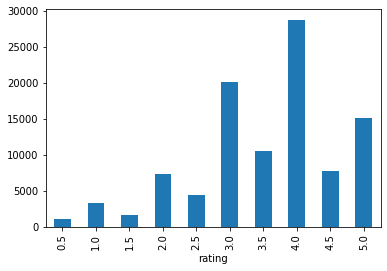

In [60]:
ratings.groupby('rating').count()['userId'].plot.bar()

<AxesSubplot:xlabel='original_title'>

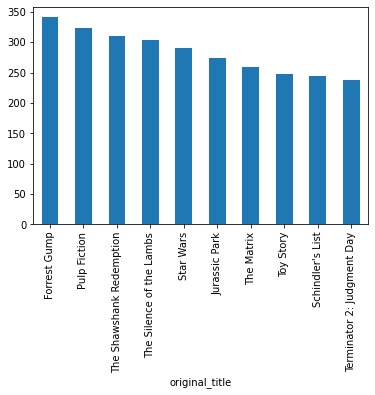

In [61]:
CFdf.groupby('original_title').count()['userId'].sort_values(ascending=False).head(10).plot.bar()

In [62]:
# Tách tên phim và id để sau này sử dụng
movies = CFdf[['movieId' , 'original_title']].drop_duplicates(['movieId' , 'original_title'])
users = CFdf[['userId']].drop_duplicates(['userId'])

In [63]:
reader = Reader()
data = Dataset.load_from_df(CFdf[['userId', 'movieId', 'rating']], reader)

# Tạo ra 1 set các user và phim không có trong dataset, set này là nơi cuối cùng chúng ta cần dự đoán đánh giá của user
anti_set = data.build_full_trainset().build_anti_testset()


In [64]:
#Hàm tính trung bình 
def Average(lst):
    return sum(lst) / len(lst)

In [65]:
from surprise.model_selection import KFold
from surprise import accuracy

# Sử dụng thư viện surprise để hỗ trợ trong việc dự đoán đánh giá của user 
# Cụ thể là sử dụng K-NN để dự đoán
# Tiến hành việc đánh giá thuật toán với cross-validation
best_pred = None
best_rmse = 100.0
rmse_list = []

time_begin = time.time()

sim_options = {
    "name": "cosine",
    "user_based": False,  # == Item-based: tính toán độ tương tự giữa các movie với nhau
}

kf = KFold(n_splits=5)
algo = KNNWithMeans(sim_options=sim_options)

for trainset, testset in kf.split(data):
    # train và test thuật toán.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Tính RMSE
    rmse = accuracy.rmse(predictions, verbose=True)
    rmse_list.append(rmse)
    # So sánh các nhóm test và lấy nhóm test có RMSE tốt nhất
    if rmse < best_rmse:
        best_rmse= rmse
        best_pred = predictions
        
time_end = time.time()
    

print('\nMean RMSE: ', Average(rmse_list))
print(f"Thời gian chạy: {time_end - time_begin}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9300
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9113
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9262
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9174
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9164

Mean RMSE:  0.9202657175919337
Thời gian chạy: 115.13583469390869


In [66]:
best_pred

[Prediction(uid=99, iid=1022, r_ui=3.0, est=3.276152020955382, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=222, iid=3580, r_ui=5.0, est=3.5259434273570833, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=130, iid=594, r_ui=4.0, est=3.3934472027106057, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=505, iid=3545, r_ui=3.5, est=3.285030581149761, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=471, iid=44022, r_ui=3.5, est=3.3942252468785217, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=15, iid=31685, r_ui=0.5, est=2.6242176973384126, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=509, iid=506, r_ui=2.0, est=2.8175093386524415, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=566, iid=102125, r_ui=5.0, est=4.41711920027824, details={'actual_k': 15, 'was_impossible': False}),
 Prediction(uid=665, iid=2502, r_ui=3.0, es

In [67]:
# Kết quả sau khi dự đoán trên rating có sẵn
pred_df = pd.DataFrame(best_pred).merge(CFdf , left_on = ['uid', 'iid'], right_on = ['userId', 'movieId'])
pred_df[['uid', 'iid', 'userId', 'movieId','original_title', 'est','rating']].head(50)

,uid,iid,userId,movieId,original_title,est,rating
0,99,1022,99,1022,Cinderella,3.276152,3.0
1,222,3580,222,3580,Up at the Villa,3.525943,5.0
2,130,594,130,594,Snow White and the Seven Dwarfs,3.393447,4.0
3,505,3545,505,3545,Cabaret,3.285031,3.5
4,471,44022,471,44022,Ice Age: The Meltdown,3.394225,3.5
5,15,31685,15,31685,Hitch,2.624218,0.5
6,509,506,509,506,Orlando,2.817509,2.0
7,566,102125,566,102125,Iron Man 3,4.417119,5.0
8,665,2502,665,2502,Office Space,4.031621,3.0
9,294,4132,294,4132,Mannequin,3.303454,3.0


In [68]:
pred_df[['uid', 'iid', 'userId', 'movieId','original_title', 'est','rating']]

,uid,iid,userId,movieId,original_title,est,rating
0,99,1022,99,1022,Cinderella,3.276152,3.0
1,222,3580,222,3580,Up at the Villa,3.525943,5.0
2,130,594,130,594,Snow White and the Seven Dwarfs,3.393447,4.0
3,505,3545,505,3545,Cabaret,3.285031,3.5
4,471,44022,471,44022,Ice Age: The Meltdown,3.394225,3.5
...,...,...,...,...,...,...,...
18935,575,1220,575,1220,The Blues Brothers,3.762298,5.0
18936,441,2987,441,2987,Who Framed Roger Rabbit,3.654526,3.5
18937,212,180,212,180,Mallrats,3.068724,3.5
18938,284,1073,284,1073,Willy Wonka & the Chocolate Factory,3.794534,3.0


In [69]:
# Sử dụng thư viện surprise để hỗ trợ trong việc dự đoán đánh giá của user 
# Cụ thể là sử dụng SVD để dự đoán
# Tiến hành việc đánh giá thuật toán với cross-validation
best_pred = None
best_rmse = 100.0
rmse_list = []

kf = KFold(n_splits=5)
algo = SVD()

time_begin = time.time()

for trainset, testset in kf.split(data):
    # train và test thuật toán.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Tính RMSE
    rmse = accuracy.rmse(predictions, verbose=True)
    rmse_list.append(rmse)
    # So sánh các nhóm test và lấy nhóm test có RMSE tốt nhất
    if rmse < best_rmse:
        best_rmse= rmse
        best_pred = predictions

time_end = time.time()
    
print('\nMean RMSE: ', Average(rmse_list))
print('Thời gian chạy: ' ,time_end - time_begin)

RMSE: 0.8934
RMSE: 0.9027
RMSE: 0.8952
RMSE: 0.8855
RMSE: 0.8957

Mean RMSE:  0.8945093055715884
Thời gian chạy:  15.72508978843689


In [70]:
best_pred

[Prediction(uid=624, iid=2410, r_ui=3.0, est=2.603626689784704, details={'was_impossible': False}),
 Prediction(uid=461, iid=4033, r_ui=3.5, est=3.6593574792185337, details={'was_impossible': False}),
 Prediction(uid=330, iid=1950, r_ui=4.0, est=3.447769817258281, details={'was_impossible': False}),
 Prediction(uid=564, iid=2289, r_ui=4.0, est=4.482299004889925, details={'was_impossible': False}),
 Prediction(uid=605, iid=934, r_ui=4.0, est=3.0050428103572107, details={'was_impossible': False}),
 Prediction(uid=654, iid=37733, r_ui=4.5, est=4.168812381254711, details={'was_impossible': False}),
 Prediction(uid=461, iid=3841, r_ui=0.5, est=2.5122343475708773, details={'was_impossible': False}),
 Prediction(uid=138, iid=79132, r_ui=5.0, est=3.435263426886742, details={'was_impossible': False}),
 Prediction(uid=240, iid=3948, r_ui=4.0, est=3.630848327732123, details={'was_impossible': False}),
 Prediction(uid=598, iid=3408, r_ui=4.0, est=3.601219320281195, details={'was_impossible': False

In [71]:
# Kết quả sau khi dự đoán trên rating có sẵn
pred_df = pd.DataFrame(best_pred).merge(CFdf , left_on = ['uid', 'iid'], right_on = ['userId', 'movieId'])
pred_df[['uid', 'iid', 'userId', 'movieId','original_title', 'est','rating']].head(50)

,uid,iid,userId,movieId,original_title,est,rating
0,624,2410,624,2410,Rocky III,2.603627,3.0
1,461,4033,461,4033,Thirteen Days,3.659357,3.5
2,330,1950,330,1950,In the Heat of the Night,3.447770,4.0
3,564,2289,564,2289,The Player,4.482299,4.0
4,605,934,605,934,Father of the Bride,3.005043,4.0
5,654,37733,654,37733,A History of Violence,4.168812,4.5
6,461,3841,461,3841,Air America,2.512234,0.5
7,138,79132,138,79132,Inception,3.435263,5.0
8,240,3948,240,3948,Meet the Parents,3.630848,4.0
9,598,3408,598,3408,Erin Brockovich,3.601219,4.0


In [72]:
pred_df[['uid', 'iid', 'userId', 'movieId','original_title', 'est','rating']]

,uid,iid,userId,movieId,original_title,est,rating
0,624,2410,624,2410,Rocky III,2.603627,3.0
1,461,4033,461,4033,Thirteen Days,3.659357,3.5
2,330,1950,330,1950,In the Heat of the Night,3.447770,4.0
3,564,2289,564,2289,The Player,4.482299,4.0
4,605,934,605,934,Father of the Bride,3.005043,4.0
...,...,...,...,...,...,...,...
18935,294,4299,294,4299,A Knight's Tale,3.863356,3.0
18936,289,1713,289,1713,MouseHunt,2.846017,3.0
18937,536,22,536,22,Copycat,3.856112,5.0
18938,33,4378,33,4378,Sexy Beast,3.277402,3.0


In [73]:
# Tiến hành dự đoán trên mẫu không có rating
anti_pre = algo.test(anti_set)
pred_df = pd.DataFrame(anti_pre).merge(movies , left_on = ['iid'], right_on = ['movieId'])
pred_df = pd.DataFrame(pred_df).merge(users , left_on = ['uid'], right_on = ['userId'])

In [74]:
pred_df

,uid,iid,r_ui,est,details,movieId,original_title,userId
0,7,2,3.526732,3.199966,{'was_impossible': False},2,Jumanji,7
1,7,3,3.526732,2.814423,{'was_impossible': False},3,Grumpier Old Men,7
2,7,4,3.526732,2.659521,{'was_impossible': False},4,Waiting to Exhale,7
3,7,5,3.526732,2.915629,{'was_impossible': False},5,Father of the Bride Part II,7
4,7,6,3.526732,3.790089,{'was_impossible': False},6,Heat,7
...,...,...,...,...,...,...,...,...
5204181,182,1405,3.526732,3.448215,{'was_impossible': False},1405,Beavis and Butt-Head Do America,182
5204182,182,1408,3.526732,4.209859,{'was_impossible': False},1408,The Last of the Mohicans,182
5204183,182,534,3.526732,4.188320,{'was_impossible': False},534,Shadowlands,182
5204184,182,318,3.526732,4.950104,{'was_impossible': False},318,The Shawshank Redemption,182


In [75]:
def getRecommendCF (userId):
    result_df = pred_df[(pred_df['est']>3.0)&(pred_df['userId']==userId)].sort_values(by=['est'], ascending=False).head(10)
    return result_df[['movieId', 'original_title', 'est', 'userId' ]].reset_index(drop=True)

In [76]:
user_id = 5
getRecommendCF(user_id)

,movieId,original_title,est,userId
0,318,The Shawshank Redemption,4.766916,5
1,899,Singin' in the Rain,4.731589,5
2,2300,The Producers,4.726416,5
3,527,Schindler's List,4.683397,5
4,50,The Usual Suspects,4.673685,5
5,3476,Jacob's Ladder,4.659799,5
6,922,Sunset Boulevard,4.656966,5
7,923,Citizen Kane,4.655372,5
8,1276,Cool Hand Luke,4.651629,5
9,1228,Raging Bull,4.620751,5
